![](https://www.finplus.co.in/wp-content/uploads/2017/10/Top-Categories-In-Online-Retail-In-India.jpg)

## Overview
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Business Goal
We aim to segement the Customers based on RFM so that the company can target its customers efficiently.

#### The steps are broadly divided into:

1. [Step 1: Reading and Understanding the Data](#1)
1. [Step 2: Data Cleansing](#2)
1. [Step 3: Data Preparation](#3)
1. [Step 4: Model Building](#4)
1. [Step 5: Final Analysis](#5)

<a id="1"></a> <br>
## Step 1 : Reading and Understanding Data

In [1]:
# For dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

os.chdir('data')
from colorsetup import colors, palette
sns.set_palette(palette)

# For clustering
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [75]:
# Reading the data on which analysis needs to be done

data = pd.read_csv('OnlineRetail.csv',sep=",",  encoding="ISO-8859-1")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [76]:
data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [78]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [79]:
data.describe(include='O')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,31-10-2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


So we are only looking at 4373 customers from this online retail business.

In [81]:
(data.isna().sum()*100)/data.shape[0]

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

Looking at the missing CustomerID, it would not make sense to impute them in anyway because it can cause some spurious grouping to be formed on any one segment of the customer ID. Hence, we are deciding to drop these ID.

In [80]:
data = data.dropna()

In [83]:
data['CustomerID'] = data['CustomerID'].astype(str)

In [82]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%d-%m-%Y %H:%M')

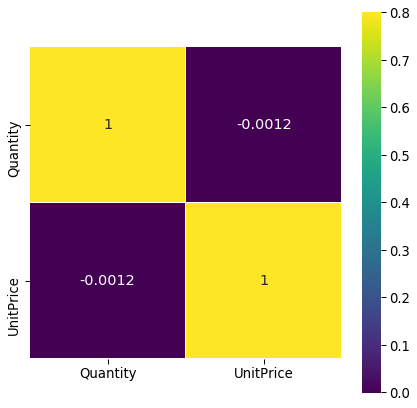

In [84]:
#All are badly correlated
corr = data.corr()
plt.figure(figsize=(7, 7))
sns.color_palette("viridis")
sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")

<a id="3"></a> <br>
## Step 3 : Data Preparation

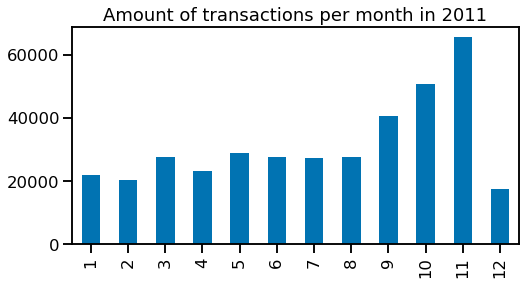

In [89]:
sns.set_context("talk")
sns.set_palette("colorblind")
plt.figure(figsize=(8,4))
data[data.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar')
plt.title("Amount of transactions per month in 2011")
plt.show()

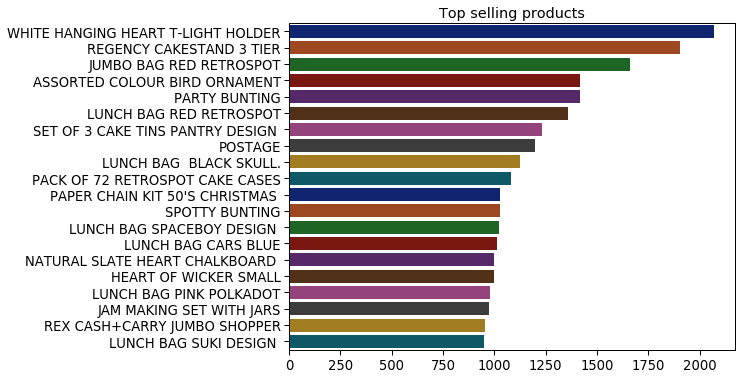

In [14]:
# Let's visualize some top products from the whole range
top_products = data['Description'].value_counts()[:20]
plt.figure(figsize=(8,6))
sns.set_context("paper", font_scale=1.5)
sns.barplot(y = top_products.index,
            x = top_products.values, 
           palette='dark')
plt.title("Top selling products")
plt.show()

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [17]:
# New Attribute : Monetary

data['Amount'] = data['Quantity'] * data['UnitPrice']
Amount = data.groupby('CustomerID')['Amount'].sum()
Amount = Amount.reset_index()
Amount.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [18]:
# New Attribute : Frequency

Freq = data.groupby('CustomerID')['InvoiceNo'].count()
Freq = Freq.reset_index()
Freq.columns = ['CustomerID', 'Frequency']
Freq.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [20]:
# Compute the maximum date to know the last transaction date

max_dt = max(data['InvoiceDate'])
data['Diff'] = max_dt - data['InvoiceDate']
data['Diff']=data['Diff'].dt.days
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373


In [28]:
max_dt = max(data['InvoiceDate'])
data['Diff'] = max_dt - data['InvoiceDate']
data['Diff']=data['Diff'].dt.days
data.head()

LatestDt = data.groupby('CustomerID')['Diff'].min()
LatestDt = LatestDt.reset_index()
LatestDt.columns = ['CustomerID','Recency']
LatestDt.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [29]:
data_new = pd.merge(Amount, Freq, how='inner', on ='CustomerID')
data_new = pd.merge(data_new, LatestDt, how='inner', on ='CustomerID')
data_new.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


#### There are 2 types of outliers and we will treat outliers as it can skew our dataset
- Statistical
- Domain specific

Text(0.5, 0, 'Attributes')

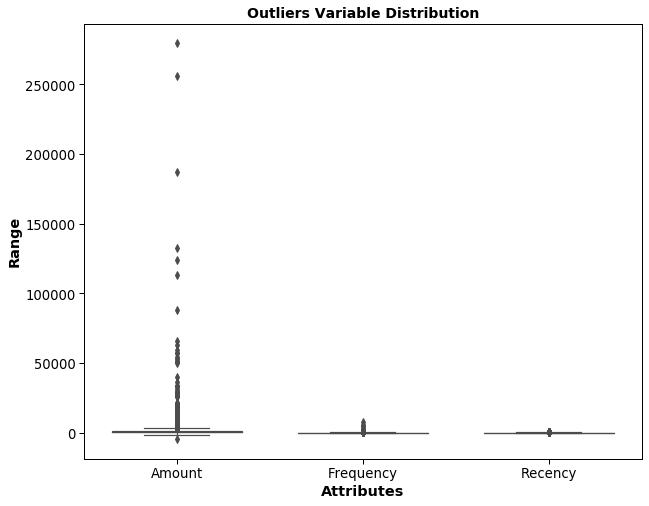

In [30]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = data_new[attributes], orient="v", palette="deep" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [31]:
# Removing (statistical) outliers for Amount
Q1 = data_new.Amount.quantile(0.05)
Q3 = data_new.Amount.quantile(0.95)
IQR = Q3 - Q1
data_new = data_new[(data_new.Amount >= Q1 - 1.5*IQR) & (data_new.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = data_new.Recency.quantile(0.05)
Q3 = data_new.Recency.quantile(0.95)
IQR = Q3 - Q1
data_new = data_new[(data_new.Recency >= Q1 - 1.5*IQR) & (data_new.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = data_new.Frequency.quantile(0.05)
Q3 = data_new.Frequency.quantile(0.95)
IQR = Q3 - Q1
data_new = data_new[(data_new.Frequency >= Q1 - 1.5*IQR) & (data_new.Frequency <= Q3 + 1.5*IQR)]

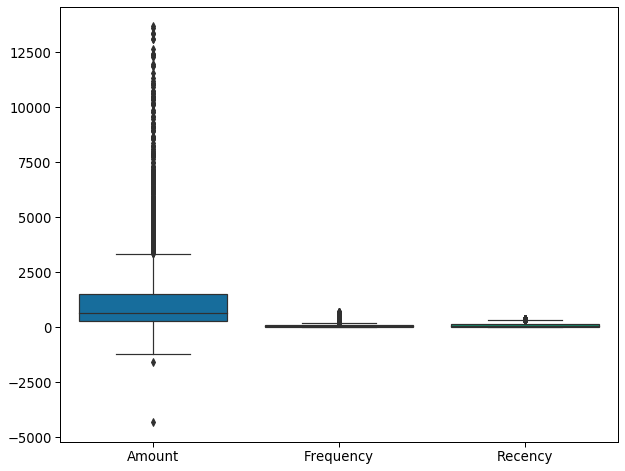

In [32]:
sns.boxplot(data=data_new[attributes])

### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.|
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

Here, we will use Standardisation Scaling.

In [33]:
from sklearn.preprocessing import MinMaxScaler

ScaleVar = data_new[['Amount', 'Frequency', 'Recency']]

mms = StandardScaler()

for col in attributes:
    data_new[col] = mms.fit_transform(ScaleVar)

data_new.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,-0.723738,-0.723738,-0.723738
1,12347.0,1.731617,1.731617,1.731617
2,12348.0,0.300128,0.300128,0.300128
3,12349.0,0.277517,0.277517,0.277517
4,12350.0,-0.533235,-0.533235,-0.533235


<a id="4"></a> <br>
## Step 4 : Building the Model

In [34]:
cluster_df = data_new.drop('CustomerID', axis=1)
cluster_df.head()

,Amount,Frequency,Recency
0,-0.723738,-0.723738,-0.723738
1,1.731617,1.731617,1.731617
2,0.300128,0.300128,0.300128
3,0.277517,0.277517,0.277517
4,-0.533235,-0.533235,-0.533235


### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

In [36]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(cluster_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [37]:
kmeans.labels_

array([3, 2, 0, ..., 3, 3, 0])

In [40]:
set(kmeans.labels_)

{0, 1, 2, 3}

### Finding the Optimal Number of Clusters

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

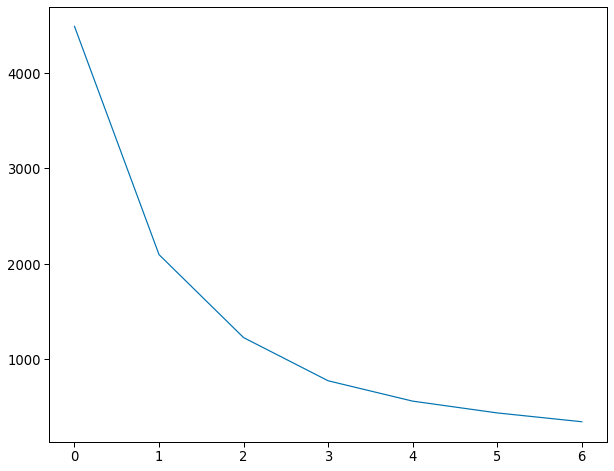

In [41]:
# Elbow-curve/SSD

inertia = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(cluster_df)
    
    inertia.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(inertia)

Possible Clusters at 2 or 3

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [25]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num in range_n_clusters:
    
    kmeans = KMeans(n_clusters=num, max_iter=50)
    kmeans.fit(cluster_df)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(cluster_df, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4816551560193964
For n_clusters=5, the silhouette score is 0.4646444032280179
For n_clusters=6, the silhouette score is 0.4171229822428261
For n_clusters=7, the silhouette score is 0.4163434484832087
For n_clusters=8, the silhouette score is 0.4097764149832758


In [42]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(cluster_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [43]:
 kmeans.labels_

array([2, 0, 0, ..., 2, 2, 0])

In [44]:
data_new['Cluster_Id'] = kmeans.labels_
data_new.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,-0.723738,-0.723738,-0.723738,2
1,12347.0,1.731617,1.731617,1.731617,0
2,12348.0,0.300128,0.300128,0.300128,0
3,12349.0,0.277517,0.277517,0.277517,0
4,12350.0,-0.533235,-0.533235,-0.533235,2


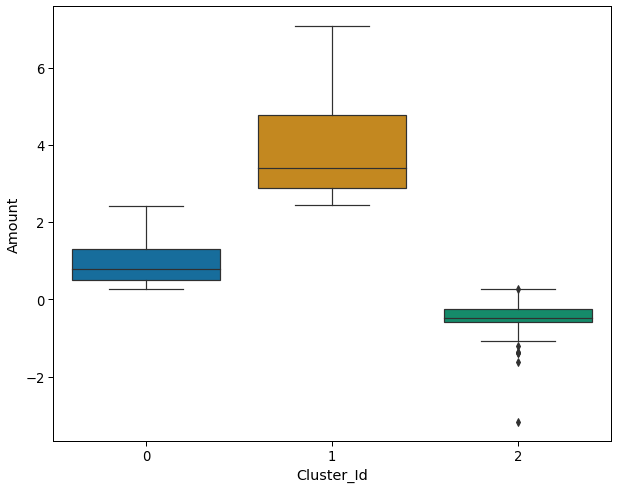

In [45]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Amount', data=data_new)

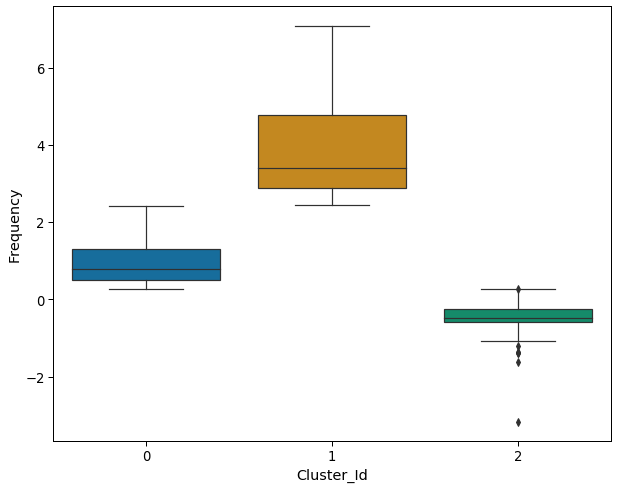

In [47]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=data_new)

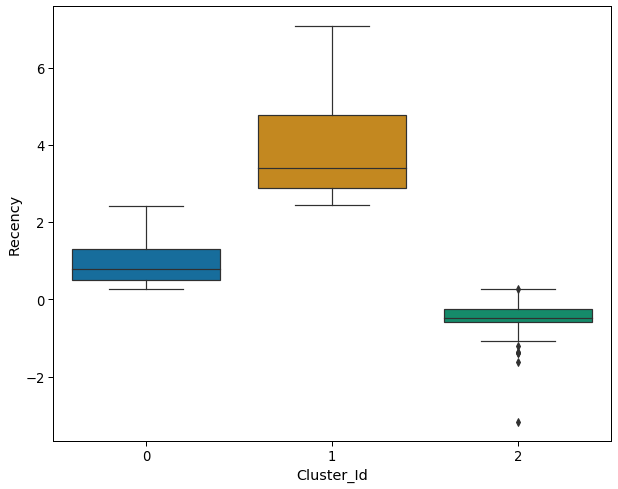

In [48]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=data_new)

Text(0.5, 0, 'Clusters')

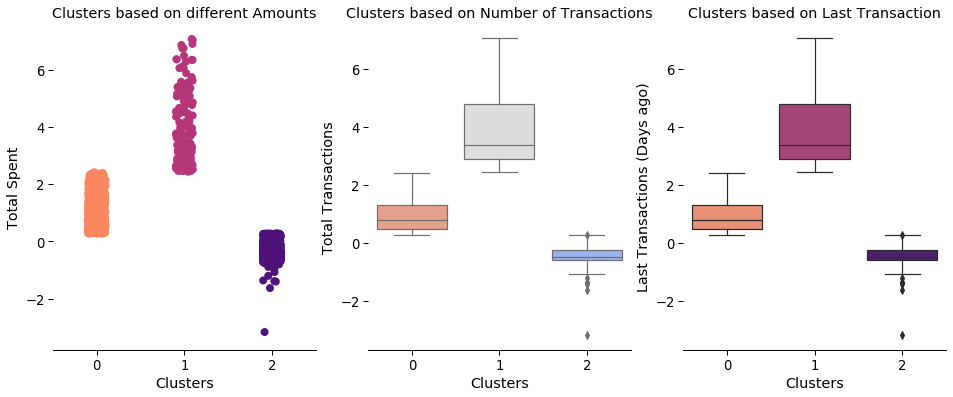

In [50]:
fig, ax =plt.subplots(nrows= 1, ncols = 3, figsize= (16,6))
ty=sns.stripplot(x='Cluster_Id', y='Amount', data=data_new, s=8, ax = ax[0], palette='magma_r')
sns.despine(left=True)
ty.set_title('Clusters based on different Amounts')
ty.set_ylabel('Total Spent')
ty.set_xlabel('Clusters')

tt=sns.boxplot(x='Cluster_Id', y='Frequency', data=data_new, ax = ax[1], palette='coolwarm_r')
tt.set_title('Clusters based on Number of Transactions')
tt.set_ylabel('Total Transactions')
tt.set_xlabel('Clusters')

tr=sns.boxplot(x='Cluster_Id', y='Recency', data=data_new, ax = ax[2], palette='magma_r')
tr.set_title('Clusters based on Last Transaction')
tr.set_ylabel('Last Transactions (Days ago)')
tr.set_xlabel('Clusters')

### Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering, 
- Divisive 
- Agglomerative.

**Single Linkage:<br>**

In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two closest points.
![](https://www.saedsayad.com/images/Clustering_single.png)

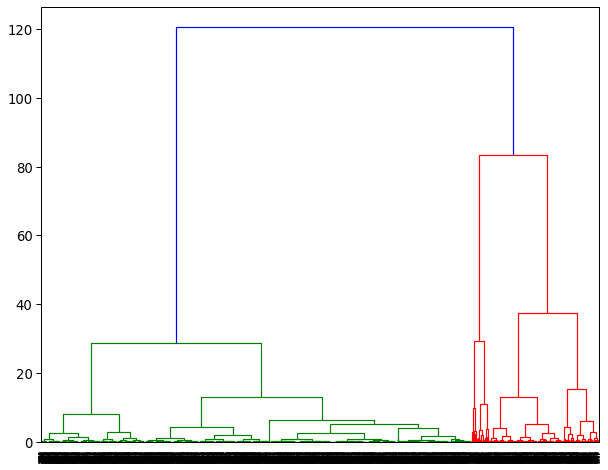

In [51]:
# Ward linkage: 

mergings = linkage(cluster_df, method="ward", metric='euclidean')
dendrogram(mergings)
plt.show()

**Complete Linkage<br>**

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points. 
![](https://www.saedsayad.com/images/Clustering_complete.png)

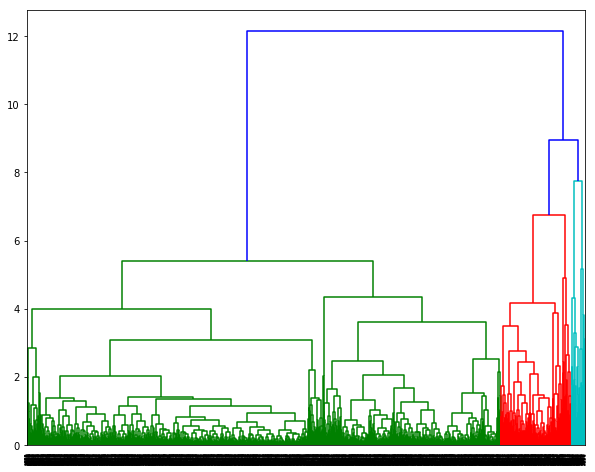

In [33]:
# Complete linkage

mergings = linkage(cluster_df, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

**Average Linkage:<br>**

In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” to the left is equal to the average length each arrow between connecting the points of one cluster to the other.
![](https://www.saedsayad.com/images/Clustering_average.png)

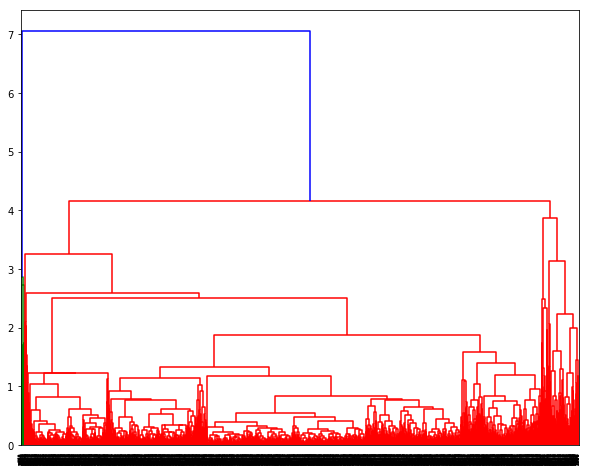

In [34]:
# Average linkage

mergings = linkage(cluster_df, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

#### Cutting the Dendrogram based on K

In [54]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, ..., 0, 0, 1])

In [55]:
data_new['Cluster_Labels'] = cluster_labels
data_new.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,-0.723738,-0.723738,-0.723738,2,0
1,12347.0,1.731617,1.731617,1.731617,0,1
2,12348.0,0.300128,0.300128,0.300128,0,1
3,12349.0,0.277517,0.277517,0.277517,0,1
4,12350.0,-0.533235,-0.533235,-0.533235,2,0


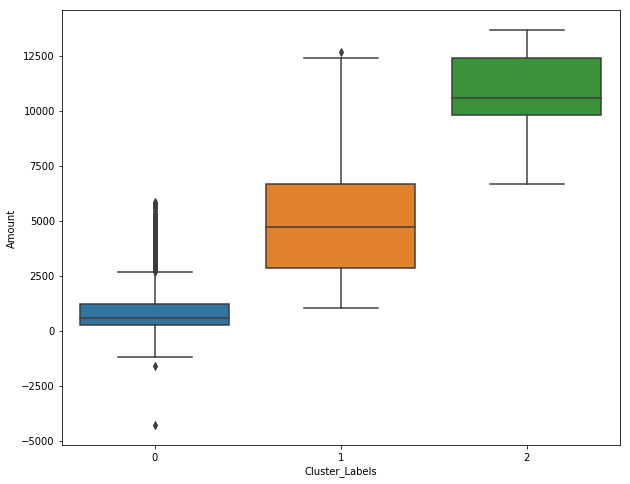

In [37]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

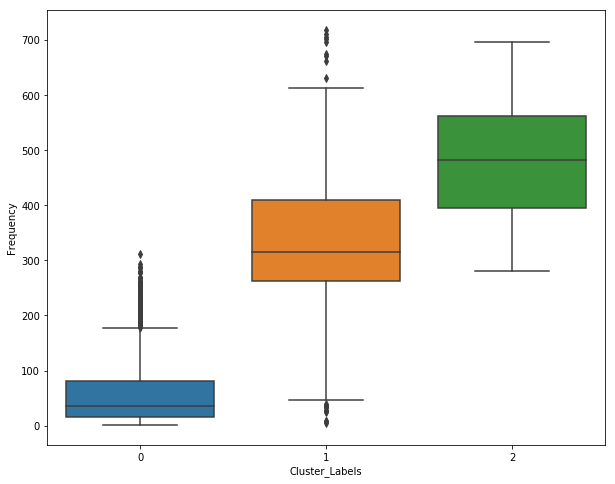

In [38]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

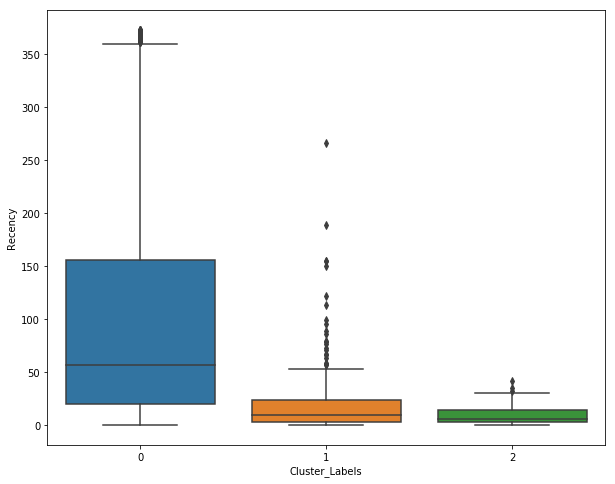

In [39]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

Text(0.5, 0, 'Clusters')

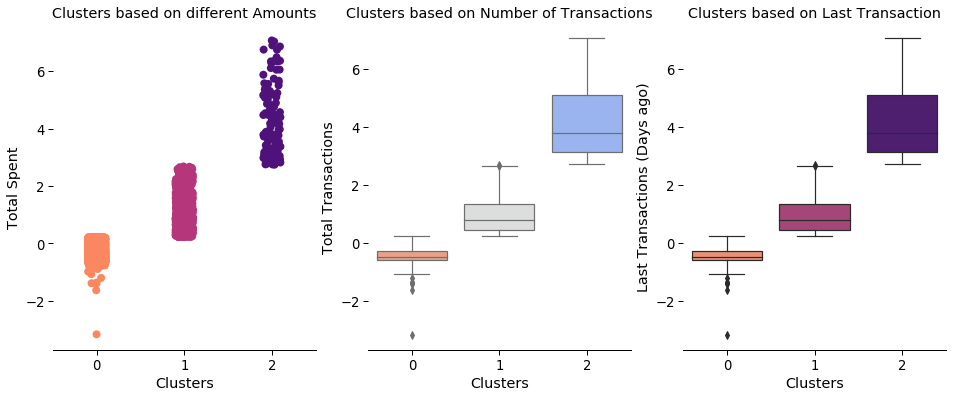

In [56]:
fig, ax =plt.subplots(nrows= 1, ncols = 3, figsize= (16,6))
ty=sns.stripplot(x='Cluster_Labels', y='Amount', data=data_new, s=8, ax = ax[0], palette='magma_r')
sns.despine(left=True)
ty.set_title('Clusters based on different Amounts')
ty.set_ylabel('Total Spent')
ty.set_xlabel('Clusters')

tt=sns.boxplot(x='Cluster_Labels', y='Frequency', data=data_new, ax = ax[1], palette='coolwarm_r')
tt.set_title('Clusters based on Number of Transactions')
tt.set_ylabel('Total Transactions')
tt.set_xlabel('Clusters')

tr=sns.boxplot(x='Cluster_Labels', y='Recency', data=data_new, ax = ax[2], palette='magma_r')
tr.set_title('Clusters based on Last Transaction')
tr.set_ylabel('Last Transactions (Days ago)')
tr.set_xlabel('Clusters')

In [91]:
db = pd.merge(Amount, Freq, how='inner', on ='CustomerID')
db = pd.merge(db, LatestDt, how='inner', on ='CustomerID')
db.drop('CustomerID', axis=1).head()

,Amount,Frequency,Recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309


Text(0.5, 0, 'Clusters')

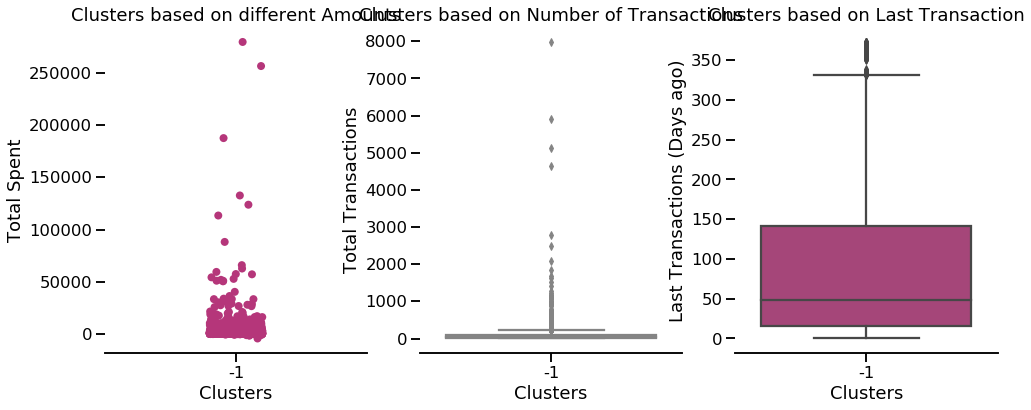

In [92]:
from sklearn.cluster import DBSCAN 

dbscan = DBSCAN(eps=1, min_samples=3).fit(db)

db['dbscan'] = dbscan.labels_


fig, ax =plt.subplots(nrows= 1, ncols = 3, figsize= (16,6))
ty=sns.stripplot(x='dbscan', y='Amount', data=db, s=8, ax = ax[0], palette='magma_r')
sns.despine(left=True)
ty.set_title('Clusters based on different Amounts')
ty.set_ylabel('Total Spent')
ty.set_xlabel('Clusters')

tt=sns.boxplot(x='dbscan', y='Frequency', data=db, ax = ax[1], palette='coolwarm_r')
tt.set_title('Clusters based on Number of Transactions')
tt.set_ylabel('Total Transactions')
tt.set_xlabel('Clusters')

tr=sns.boxplot(x='dbscan', y='Recency', data=db, ax = ax[2], palette='magma_r')
tr.set_title('Clusters based on Last Transaction')
tr.set_ylabel('Last Transactions (Days ago)')
tr.set_xlabel('Clusters')

Text(0.5, 0, 'Clusters')

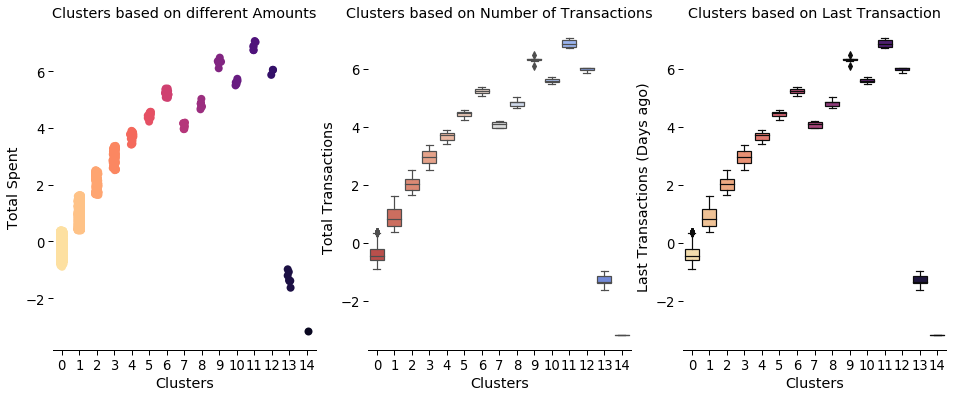

In [64]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(cluster_df, quantile=0.1)
ms = MeanShift(bandwidth).fit(cluster_df)
data_new['meanshift'] = ms.labels_

fig, ax =plt.subplots(nrows= 1, ncols = 3, figsize= (16,6))
ty=sns.stripplot(x='meanshift', y='Amount', data=data_new, s=8, ax = ax[0], palette='magma_r')
sns.despine(left=True)
ty.set_title('Clusters based on different Amounts')
ty.set_ylabel('Total Spent')
ty.set_xlabel('Clusters')

tt=sns.boxplot(x='meanshift', y='Frequency', data=data_new, ax = ax[1], palette='coolwarm_r')
tt.set_title('Clusters based on Number of Transactions')
tt.set_ylabel('Total Transactions')
tt.set_xlabel('Clusters')

tr=sns.boxplot(x='meanshift', y='Recency', data=data_new, ax = ax[2], palette='magma_r')
tr.set_title('Clusters based on Last Transaction')
tr.set_ylabel('Last Transactions (Days ago)')
tr.set_xlabel('Clusters')

In [74]:
print(bandwidth)

0.43060401722570685


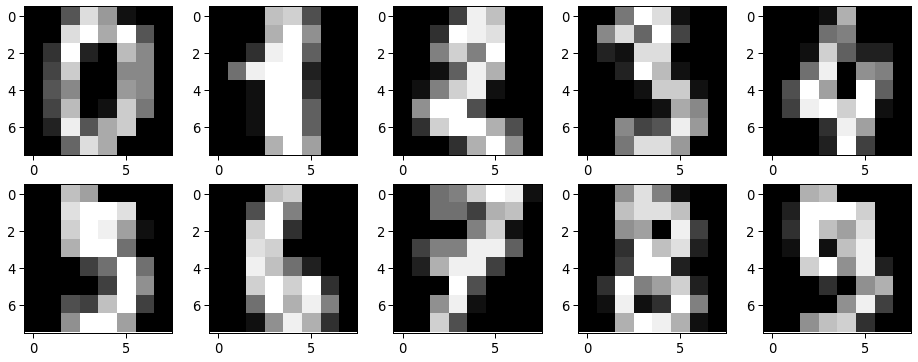

In [71]:
from sklearn import datasets

digits = datasets.load_digits()
X = digits.data
y = digits.target

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray');

Projecting 64-dimensional data to 2D


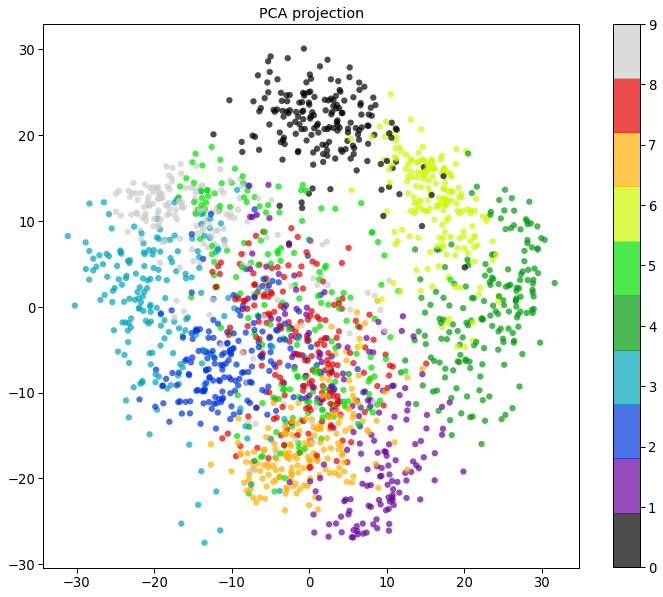

In [73]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('PCA projection');

<a id="5"></a> <br>
## Step 5 : Final Analysis

### Inference:
K-Means Clustering with 3 Cluster Ids
- Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster Id 1 are frequent buyers.
- Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.

Hierarchical Clustering with 3 Cluster Labels
- Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster_Labels 2 are frequent buyers.
- Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view.

### If this Kernel helped you in any way, some <font color="red"><b>UPVOTES</b></font> would be very much appreciated